# Work 5. Ethereum

### 0. Importing all the modules needed

In [1]:
from web3 import Web3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### 1. Constants
#### DIV is needed for countinf fees & rewards
#### PRICE is the gasPrice which is always 3 000 000 000

In [2]:
DIV = 1000000000
PRICE = 2000000000

### 2. Connecting through Infura

In [3]:
web3 = Web3(Web3.HTTPProvider('https://mainnet.infura.io/v3/0cf0910692d24d33ae46244f3189bea8'))

In [4]:
#Making sure the connection is estabilished
print(web3.isConnected())

True


### 3. Getting the blocks
#### Personal number: 35

In [10]:
blocks = []
last_block = 8961400 - 1000 * (35 - 2)
first_block = 8961400 - 1000 * (35 - 1)
print (first_block, last_block)

8927400 8928400


In [11]:
for current_block in range(first_block, last_block):
    c_block = web3.eth.getBlock(current_block)
    blocks.append(c_block)



#### Time taken: 6 m 13 sec


In [12]:
print (len(blocks), '\n')
blocks[0]

1000 



AttributeDict({'difficulty': 2573569997487818,
 'extraData': HexBytes('0x472f535a2f4254504f4f4c2f0002c7d1'),
 'gasLimit': 9929026,
 'gasUsed': 3133147,
 'hash': HexBytes('0xb8766ec72e3c3779bbe2fccad46c527b39360e0544c4aa1ad7b01255daf5bb67'),
 'logsBloom': HexBytes('0x0490102020046e8b0a04101446000048082a28610c8058a0c021405400c2182021080e611880a8a8040080069108010ed22a0402c4212064402221c900284504051d0080c208722101090208080300004182030180002010085589040883001242018000b22400280002c4803028000201382400c2c66420030082526b4010e04031020201402042000000404430010529b480224881403048030000149a801e10018004000040000021ea800280014041c4010f1004040c0018481140042002866000120001014000320c041200000004028085008009104003416c140500c0000c8044000000001022002ce010a040100030c0510020850049110204800083'),
 'miner': '0xAA5c4244F05c92781C4F259913319d8ba1aCF05E',
 'mixHash': HexBytes('0x1982277d44effa81846b3418ee014553a38b674f603e07ce9f9be7bbaedabb92'),
 'nonce': HexBytes('0x21b8de40000f0e52'),
 'number': 8927400,
 'paren

### 4. Converting the blocks into a DataFrame & getting rid of some extra data
#### Just in case of editing to save the data on the computer to avoid downloading all over again
#### Plus getting out fees, rewards & percentage

This is for the first option of formulas, with:
    - fee = gasUsed / gasLimit;
    - reward = 3 + fee / gwei + uncle reward

In [ ]:
gasused = []
uncles = []
number = []
gaslimit = []
block_fee = []
block_reward = []
percent = []

for block in blocks:
    gasused.append(block.gasUsed)
    uncles.append(block.uncles)
    number.append(block.number)
    gaslimit.append(block.gasLimit)
    block_fee.append(block.gasLimit / DIV)
    block_reward.append((PRICE + block.gasUsed) / DIV + ((PRICE * len(block.uncles)) / (DIV * 32)))
    #block_reward.append((PRICE + block.gasUsed) / DIV)
    

gas_data = pd.DataFrame.from_dict({'number': number, 'gas_limit': gaslimit, 'gas_used': gasused, 'uncles': uncles, 'block_fee': block_fee, 'block_reward': block_reward})
gas_data['percent'] = gas_data.block_fee / gas_data.block_reward * 100
gas_data

## Alternative with formulas:<br>
    - fee = gasUsed * gasPrice<br>
    - reward = static reward + fee

In [35]:
gasused = []
number = []
block_fee = []
block_reward = []
percent = []

for block in blocks:
    gasused.append(block.gasUsed)
    number.append(block.number)
    c_fee = 0
    if hasattr(block, 'transactions'):
        for transaction in range(len(block.transactions)):
            c_trans = block.transactions[transaction]
            if hasattr(block.transactions[transaction], 'gasPrice'):
                c_fee += c_trans.gasUsed * c_trans.gasPrice / DIV**2
            else:
                c_fee += c_trans.gasUsed * PRICE / DIV**2
    else:
        c_fee = block.gasUsed * PRICE / DIV**2
    block_fee.append(c_fee)
    block_reward.append(PRICE / DIV + c_fee)
    
gas_data_alt = pd.DataFrame.from_dict({'number': number, 'gas_used': gasused, 'block_fee': block_fee, 'block_reward': block_reward})
gas_data_alt['percent'] = gas_data_alt.block_fee / gas_data_alt.block_reward * 100
gas_data_alt
        

,number,gas_used,block_fee,block_reward,percent
0,8927400,3133147,0.001451,2.001451,0.072491
1,8927401,6960816,0.003229,2.003229,0.161207
2,8927402,9945509,0.009828,2.009828,0.489018
3,8927403,9943134,0.004353,2.004353,0.217157
4,8927404,8582982,0.003604,2.003604,0.179864
...,...,...,...,...,...
995,8928395,7376567,0.005569,2.005569,0.277699
996,8928396,7042923,0.004493,2.004493,0.224146
997,8928397,5335647,0.000281,2.000281,0.014039
998,8928398,9616332,0.000562,2.000562,0.028073


#### Saving our data

In [36]:
#gas_data.to_csv('data.csv', sep=';')
#gas_data.to_csv('data_wou.csv', sep=';')
gas_data_alt.to_csv('data_alt.csv', sep=';')

#### Extracting from the file in case of editing

In [ ]:
data = pd.read_csv('data.csv', sep=';', index_col=0)
data

### 5. Plotting

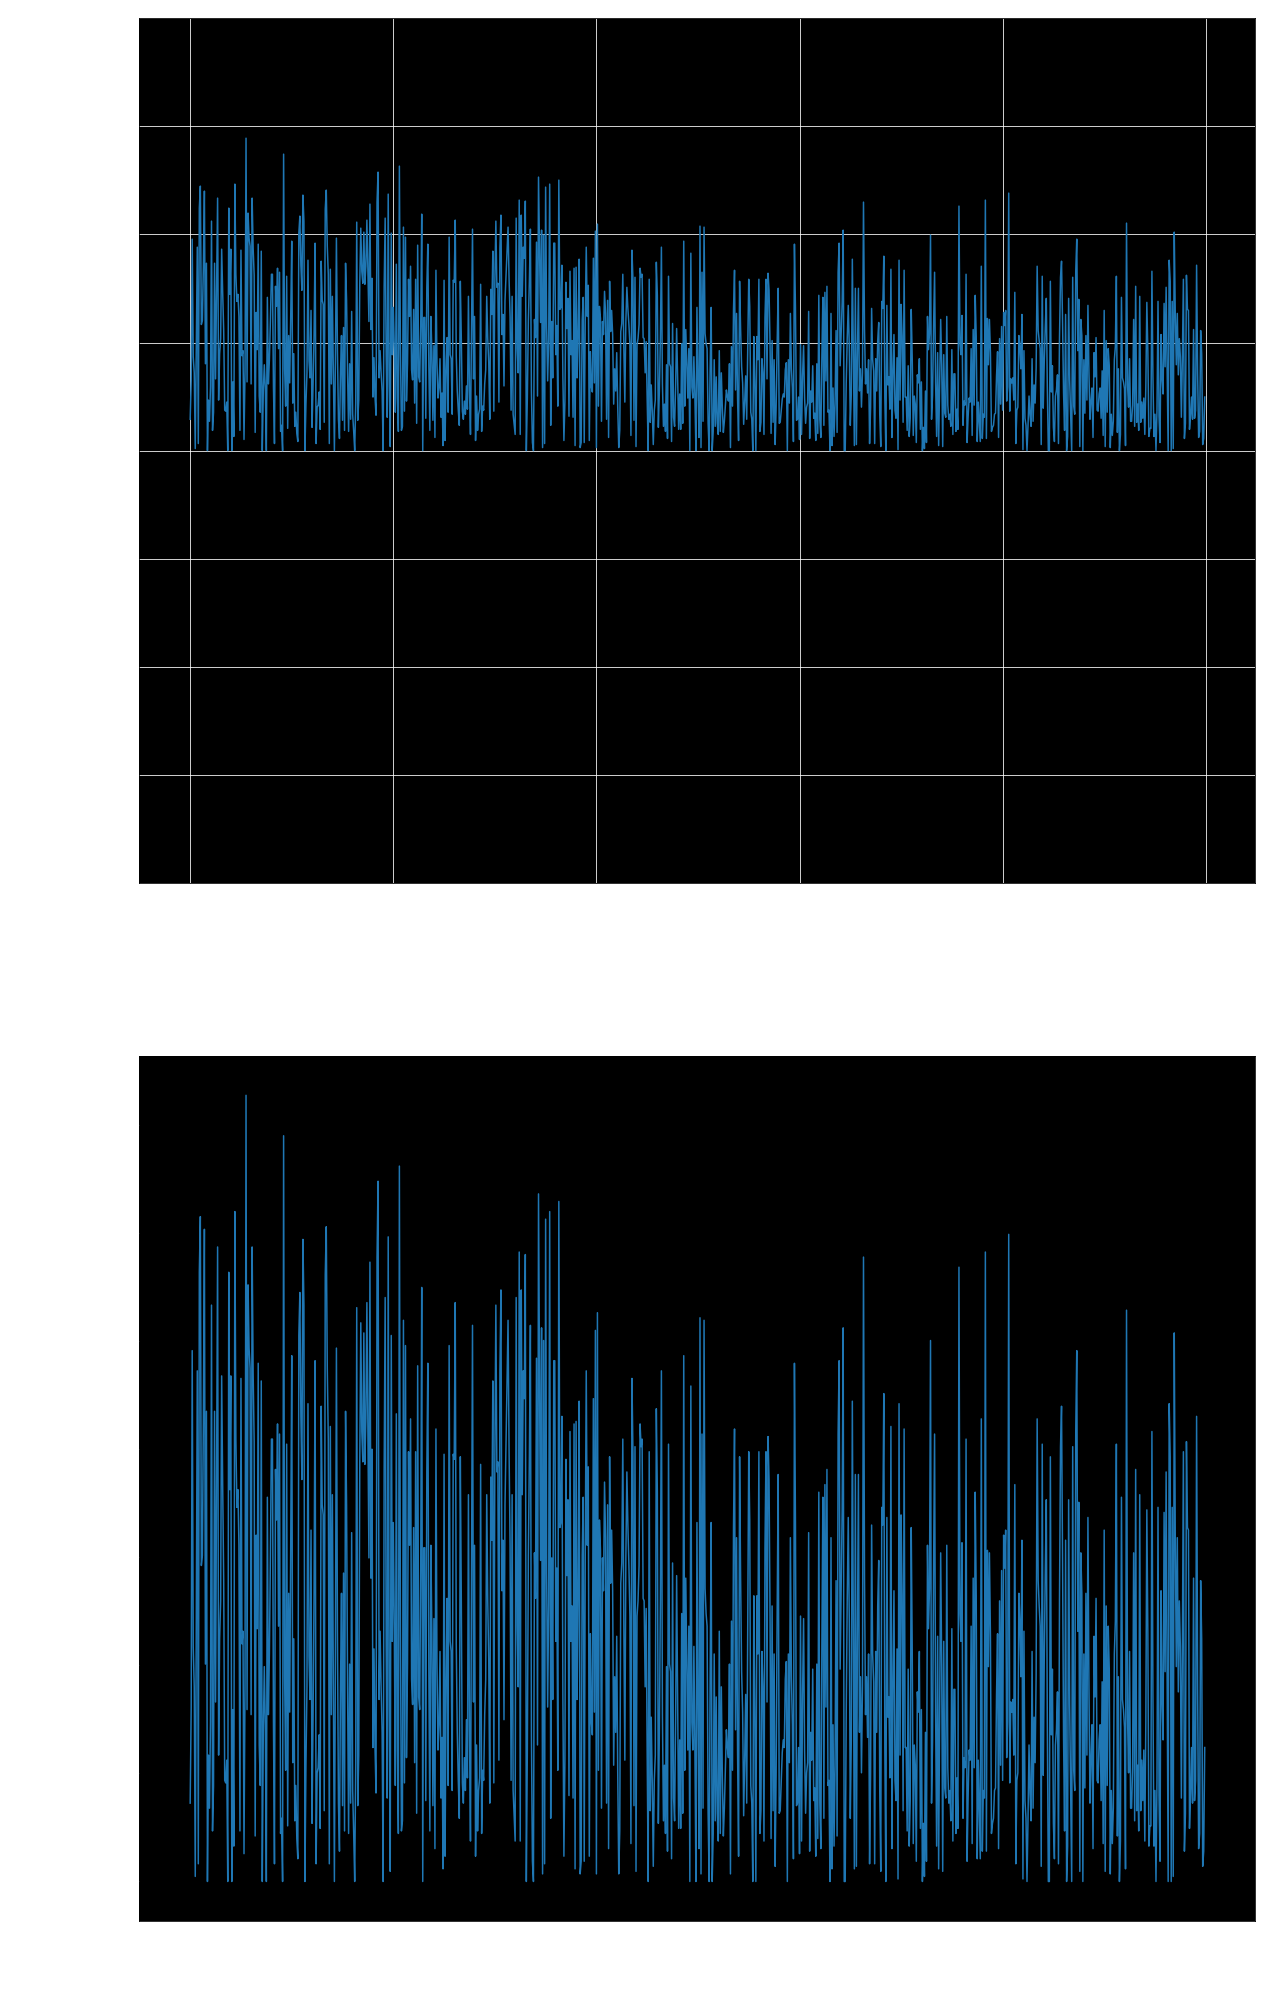

In [43]:
fig = plt.figure(figsize=(20,35))
plt.rcParams.update({'font.size': 30})

fig1 = fig.add_subplot(211)
fig1.set_facecolor('black')
fig1.tick_params(colors='white')
fig1.plot(gas_data_alt.number, gas_data_alt.percent)
plt.grid(color='white')
fig1.set_xlabel('Block number', )
fig1.set_ylabel('Fee percentage')
plt.ylim(-1, 1)
fig1.xaxis.label.set_color('white')
fig1.yaxis.label.set_color('white')

fig2 = fig.add_subplot(212)
fig2.set_facecolor('black')
fig2.tick_params(colors='white')
fig2.plot(gas_data_alt.number, gas_data_alt.block_fee)
fig2.set_xlabel('Block number', )
fig2.set_ylabel('Fee')
fig2.xaxis.label.set_color('white')
fig2.yaxis.label.set_color('white')

plt.show()

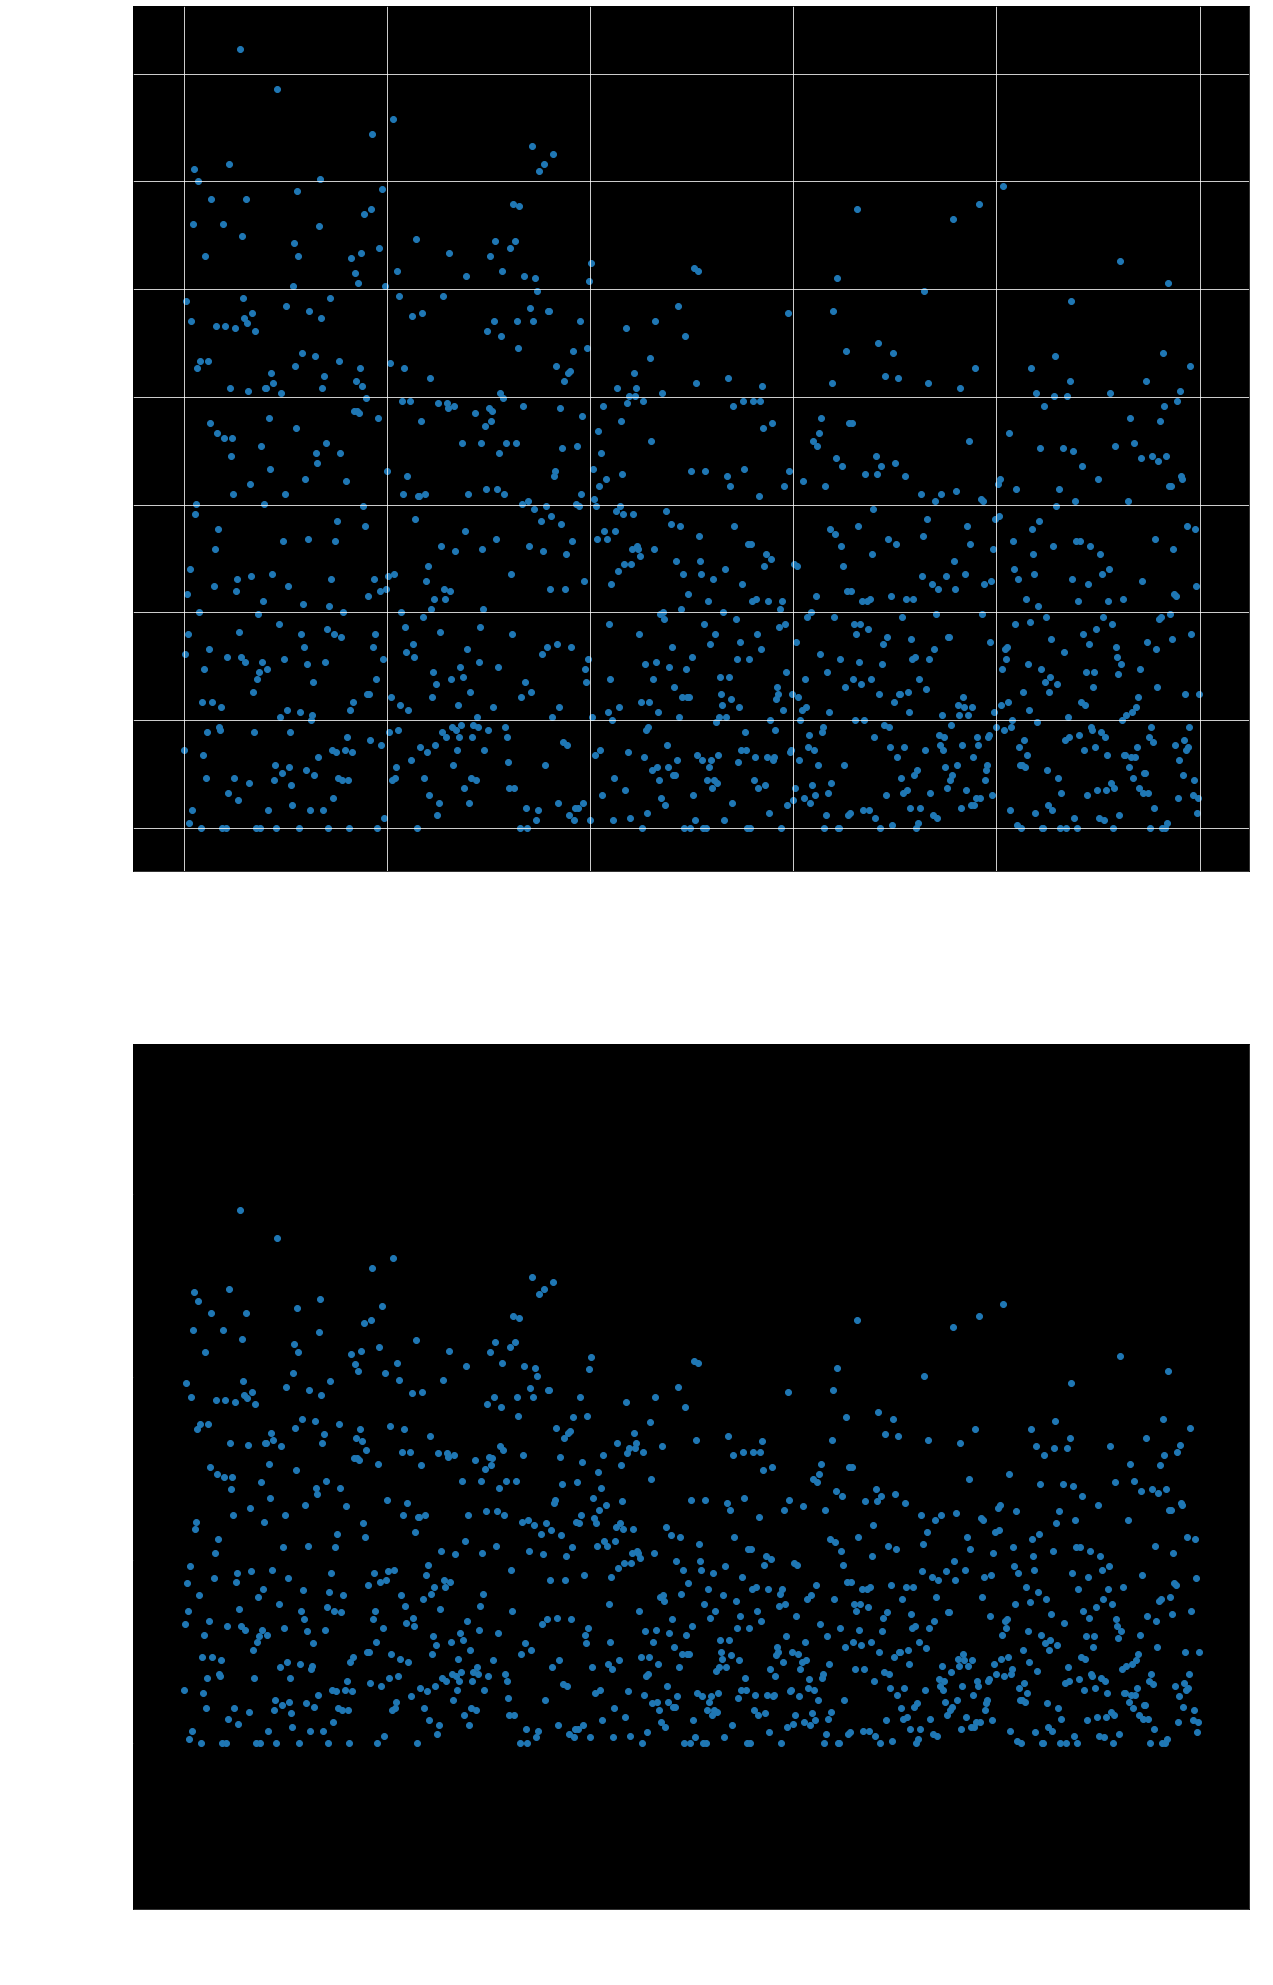

In [40]:
fig = plt.figure(figsize=(20,35))
plt.rcParams.update({'font.size': 30})

fig1 = fig.add_subplot(211)
fig1.set_facecolor('black')
fig1.tick_params(colors='white')
fig1.scatter(gas_data_alt.number, gas_data_alt.percent)
plt.grid(color='white')
fig1.set_xlabel('Block number', )
fig1.set_ylabel('Fee percentage')
fig1.xaxis.label.set_color('white')
fig1.yaxis.label.set_color('white')

fig2 = fig.add_subplot(212)
fig2.set_facecolor('black')
fig2.tick_params(colors='white')
fig2.scatter(gas_data_alt.number, gas_data_alt.block_fee)
fig2.set_xlabel('Block number', )
fig2.set_ylabel('Fee')
fig2.xaxis.label.set_color('white')
fig2.yaxis.label.set_color('white')

plt.show()

### 6. Getting our extra values
#### Expected value, dispersion, median, range, std deviation, 

In [45]:
mean = np.mean(gas_data_alt.block_fee)
dispersion = np.var(gas_data_alt.block_fee)
std_deviation = np.std(gas_data_alt.block_fee)
fee_range = np.ptp(gas_data_alt.block_fee)
med = np.median(gas_data_alt.block_fee)
print ('Expected value:', round(mean, 6))
print ('Dispersion:', round(dispersion, 9))
print ('Standard deciation:', round(std_deviation, 6))
print ('Range:', round(fee_range, 6))
print ('Median:', round(med, 6))

Expected value: 0.004254
Dispersion: 1.0149e-05
Standard deciation: 0.003186
Range: 0.014555
Median: 0.003604


/home/jarvis/anaconda3/envs/slytherin/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### P.S. Drafts just in case

In [ ]:
bla = web3.eth.getBlock(first_block)
bla

In [19]:
bla_1 = web3.eth.getTransaction('0x5894cee5a11b6e04fc3d851a80b95f2500bd726e03a6979b1af6b3f4eaec3c2f')
bla_1

AttributeDict({'blockHash': HexBytes('0xb8766ec72e3c3779bbe2fccad46c527b39360e0544c4aa1ad7b01255daf5bb67'),
 'blockNumber': 8927400,
 'from': '0x780dc27a176445Aa93bBF3c80753196e41f916eC',
 'gas': 66000,
 'gasPrice': 3000000000,
 'hash': HexBytes('0x5894cee5a11b6e04fc3d851a80b95f2500bd726e03a6979b1af6b3f4eaec3c2f'),
 'input': '0xa9059cbb0000000000000000000000005e22774f6103a940c552017ff62ad6a59849da1f00000000000000000000000000000000000000000000009d6bb5407a78d60000',
 'nonce': 3304,
 'r': HexBytes('0x4d4697f6a3c67e684668c995c141bed13c60bc6c068c6073ec7d1168ab228251'),
 's': HexBytes('0x17e02d0868e0cb97f4631be793952efa094ce5fbb43fcb453b386437333c14fc'),
 'to': '0x5d285F735998F36631F678FF41fb56A10A4d0429',
 'transactionIndex': 30,
 'v': 37,
 'value': 0})

In [ ]:
sum = 0
for place in bla.transactions:
    check = web3.eth.getTransactionReceipt(place)
    sum += check.gasUsed
sum